# The Rotten Tomatoes Effect

## By: Brandon Zhao


Growing up, my family would have "Movie Night" every Saturday, where we would all get together and watch some movie that my dad would pick out for us together. These movie nights are some of my favorite memories from my childhood, and they also instilled in me a love for the world of cinema. Even now, I continue to try to watch and learn about important films in cinema, and one my greatest resources in doing so has been Rotten Tomatoes.

Practically everyone in the modern world who watches movies has heard of Rotten Tomatoes, but for those who have not, it is a Review-Aggregation Website for films and tv shows. It takes reviews from critics and uses them to gives films a rating out of 100, as well as a label of "Fresh" or "Rotten". It's by far one of the most popular about films, and I myself use it quite frequently to learn more about different films and decide which ones to watch.

One day while using Rotten Tomatoes, I became curious about its origins and decided to look it up on Wikipedia. After reading about how the site came to be, I came to an interesting section of the Wikipedia page that talked about the site's influence on the film industry. (https://en.wikipedia.org/wiki/Rotten_Tomatoes#Influence) It stated how many film studios have come to dislike Rotten Tomatoes because of how much impact a bad rating on the site can have on the box office success of a film, named "The Rotten Tomatoes Effect". I was instantly interested in whether or not this phenomena was real. Will a bad rating or a "Rotten" label lead to less box office earnings? Will a good rating or a "Fresh" Label lead to more?

In this data analysis project, I will be answering these questions. I will be looking into how reviews on Rotten Tomatoes impact a film's box office earnings. I will also attempt to create a model that will predict a film's earnings based on its reviews on Rotten Tomatoes.

These are the packages I will be using in this project

In [115]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
import scipy

### Obtaining the Data

For this data analysis project, I will be using two datasets of movies from Kaggle. The first is from https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset, and it contains information taken from the IMDb pages of movies. The second is from https://www.kaggle.com/heyueyuan/rottentomatoesmoviesandcriticsdatasets/data, and it contains information taken from the Rotten Tomatoes pages of movies. The two datasets will need to be loaded into the workspace as "imdb_movies.csv" and "rotten_tomatoes_movies.csv" for this script to run properly.

In [116]:
imdb_df = pd.read_csv("imdb_movies.csv")
rt_df = pd.read_csv("rotten_tomatoes_movies.csv")

Here are the available fields from each original dataset.

In [117]:
print("Field names of IMDb Dataset:")
print(imdb_df.columns)
print("\n")
print("Field names of Rotten Tomatoes Dataset:")
print(rt_df.columns)

Field names of IMDb Dataset:
Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')


Field names of Rotten Tomatoes Dataset:
Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'poster_image_url', 'rating', 'genre', 'directors',
       'writers', 'cast', 'in_theaters_date', 'on_streaming_date',
       'runtime_in_minutes', 'studio_name', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_status',
       'audience_rating', 'audience_count', 'audience_top_critics_count',
       'audience_fresh_critics_count', 'audience_rotten_critics_count'],
      dtype='object')


### Cleaning the Data

To get the necessary rows and fields from each dataset, I will be using the package pandasql. This allows for working with Pandas dataframes with SQL statements. I will be using this package because it allows for easier manipulation of dataframes and it allows me to practice my SQL querying skills. I will need the title, year, country, budget, and worlwide_gross_income from the IMDb Dataset and the tomatometer_status, tomatometer_rating, and audience_rating from the Rotten Tomatoes Dataset. Furthermore, I will need to filter for title matches between the two dataframes, budget and worlwide_gross_income values that aren't missing, and movies released after 1998, the year Rotten Tomatoes was founded.

In [118]:
movies_df = sqldf("""SELECT title, year, country, budget, worlwide_gross_income AS income,
                          tomatometer_status, tomatometer_rating, audience_rating 
                     FROM imdb_df
                     INNER JOIN rt_df
                     ON imdb_df.title = rt_df.movie_title
                     WHERE year > 1998 AND budget IS NOT NULL AND worlwide_gross_income IS NOT NULL""", globals())

This is information about the resulting dataframe to be used for the rest of this data analysis

In [119]:
print(movies_df.head())
print("\n")
print(movies_df.describe(include = "all"))
print("\n")
print(movies_df.dtypes)

             title  year country      budget       income tomatometer_status  \
0   Kate & Leopold  2001     USA  $ 48000000   $ 76019048             Rotten   
1  The Fantasticks  2000     USA  $ 10000000      $ 49666             Rotten   
2          Glitter  2001     USA  $ 22000000    $ 5271666             Rotten   
3    Baby Geniuses  1999     USA  $ 12000000   $ 36450736             Rotten   
4      Three Kings  1999     USA  $ 75000000  $ 107752036    Certified Fresh   

   tomatometer_rating  audience_rating  
0                  50             62.0  
1                  50             49.0  
2                   7             48.0  
3                   2             24.0  
4                  94             77.0  


       title         year country      budget       income tomatometer_status  \
count   4706  4706.000000    4706        4706         4706               4706   
unique  4251          NaN     697         569         4321                  3   
top     Home          NaN   

The following data cleaning steps before analysis on the data can begin:

1) Strings were imported as objects, but should be converted back to strings

2) Budget and Income have a dollar sign and space in front- this should be gotten rid of so that they can be converted from strings to numeric values. Some budgets are also of different currencies. These values need to be converted to American dollars, and then to numeric values.

3) The country has 697 unique values, which seems incorrect as there are only 195 countries in the world. This is because some values in the country column contain a list of countries that the movie was made in, in order of importance. A new column titled from_USA should be added that would contain boolean values as to whether the country or the first country in the list of countries is USA.

4) A new column titled earnings should be added that would tell net gain/loss of a movie in terms of a movie by subtracting its budget from its income.

In [120]:
# Converting columns that are objects into strings
movies_df["title"] = movies_df["title"].astype(str)
movies_df["country"] = movies_df["country"].astype(str)
movies_df["budget"] = movies_df["budget"].astype(str)
movies_df["income"] = movies_df["income"].astype(str)
movies_df["tomatometer_status"] = movies_df["tomatometer_status"].astype(str)
movies_df["tomatometer_rating"] = movies_df["tomatometer_rating"].astype(float)

# Converting all Budget and Income into USD and then into numeric values
movies_df["income"] = movies_df["income"].str.replace("$", "")
movies_df["budget"] = movies_df["budget"].str.replace("$", "")
for i, b in movies_df["budget"].items() :
    if b[0:3] == "GBP" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * 1.3
    elif b[0:3] == "EUR" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * 1.18
    elif b[0:3] == "DEM" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .6
    elif b[0:3] == "CAD" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .75
    elif b[0:3] == "AUD" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .72
    elif b[0:3] == "INR" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .013
    elif b[0:3] == "DKK" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .16
    elif b[0:3] == "NOK" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .11
    elif b[0:3] == "JPY" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .0095
    elif b[0:3] == "EGP" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .063
    elif b[0:3] == "THB" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .032
    elif b[0:3] == "SEK" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .11
    elif b[0:3] == "PLN" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .27
    elif b[0:3] == "ARS" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .014
    elif b[0:3] == "NZD" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .66
    elif b[0:3] == "NGN" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .0026
    elif b[0:3] == "CNY" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .14
    elif b[0:3] == "KRW" :
        movies_df["budget"][i] = float(movies_df["budget"][i][3:]) * .00084
movies_df["income"] = movies_df["income"].astype(float)
movies_df["budget"] = movies_df["budget"].astype(float)

# Creating from_USA column
movies_df["from_USA"] = False
for i, c in movies_df["country"].items() :
    movies_df["from_USA"][i] = (movies_df["country"][i][0:3] == "USA")

# Creating earnings column
movies_df["earnings"] = movies_df["income"] - movies_df["budget"]

This is the cleaned dataframe that is now ready to be used for analysis

In [121]:
print(movies_df.head())
print("\n")
print(movies_df.describe(include = "all"))
print("\n")
print(movies_df.dtypes)

             title  year country      budget       income tomatometer_status  \
0   Kate & Leopold  2001     USA  48000000.0   76019048.0             Rotten   
1  The Fantasticks  2000     USA  10000000.0      49666.0             Rotten   
2          Glitter  2001     USA  22000000.0    5271666.0             Rotten   
3    Baby Geniuses  1999     USA  12000000.0   36450736.0             Rotten   
4      Three Kings  1999     USA  75000000.0  107752036.0    Certified Fresh   

   tomatometer_rating  audience_rating  from_USA    earnings  
0                50.0             62.0      True  28019048.0  
1                50.0             49.0      True  -9950334.0  
2                 7.0             48.0      True -16728334.0  
3                 2.0             24.0      True  24450736.0  
4                94.0             77.0      True  32752036.0  


       title         year country        budget        income  \
count   4706  4706.000000    4706  4.706000e+03  4.706000e+03   
unique  4

There seems to be some NA values in the audience_rating column. As this makes up a relatively small number of rows, rows with NA values will be dropped.

In [122]:
movies_df = movies_df.dropna()

### Exploring the Data

First, we will look at the distributions of each of the columns

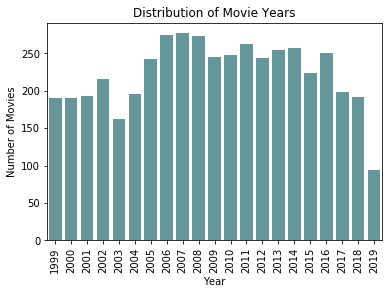

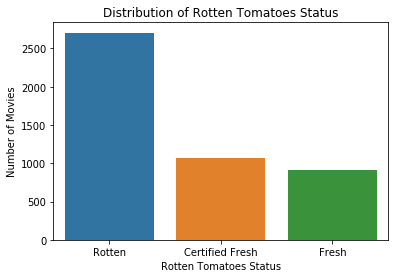

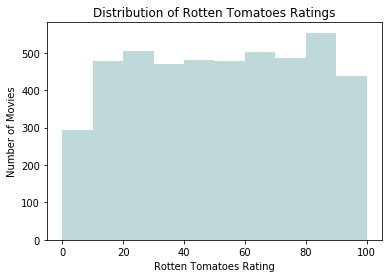

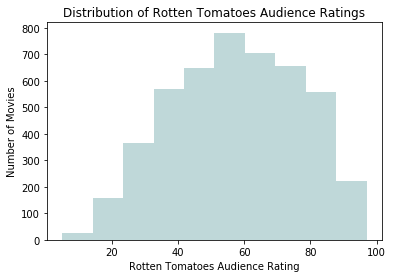

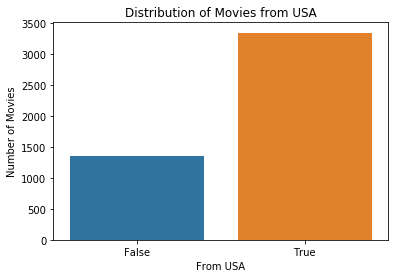

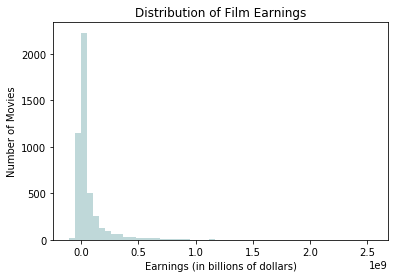

In [123]:
sns.countplot(movies_df.year, color = "cadetblue")
plt.xticks(rotation = 90)
plt.ylabel("Number of Movies")
plt.xlabel("Year")
plt.title("Distribution of Movie Years")
plt.show()
sns.countplot(movies_df.tomatometer_status)
plt.ylabel("Number of Movies")
plt.xlabel("Rotten Tomatoes Status")
plt.title("Distribution of Rotten Tomatoes Status")
plt.show()
sns.distplot(movies_df.tomatometer_rating, kde = False, bins = 10, color = "cadetblue")
plt.ylabel("Number of Movies")
plt.xlabel("Rotten Tomatoes Rating")
plt.title("Distribution of Rotten Tomatoes Ratings")
plt.show()
sns.distplot(movies_df.audience_rating, kde = False, bins = 10, color = "cadetblue")
plt.ylabel("Number of Movies")
plt.xlabel("Rotten Tomatoes Audience Rating")
plt.title("Distribution of Rotten Tomatoes Audience Ratings")
plt.show()
sns.countplot(movies_df.from_USA)
plt.ylabel("Number of Movies")
plt.xlabel("From USA")
plt.title("Distribution of Movies from USA")
plt.show()
sns.distplot(movies_df.earnings, kde = False, color = "cadetblue")
plt.ylabel("Number of Movies")
plt.xlabel("Earnings (in billions of dollars)")
plt.title("Distribution of Film Earnings")
plt.show()

The distribution of years is approximately uniform. The year 2019 seems to have less films than the other years- this is likely because the dataset was originally created in mid-2019, so not all films that were released in 2019 are in the dataset.

The distribution of Rotten Tomatotoes Status indicates that the total number of movies with the "Rotten" status is slightly more than the number of movies with the "Certified Fresh" and "Fresh" status. The number of movies with the "Certified Fresh" and "Fresh" status is approximately equal.

The distribution of Rotten Tomatoes Ratings is approximately uniform. However, there seems to be less movies with extremely low ratings (0 - 10%).

The distribution of Rotten Tomatoes Audience Ratings is closer to a normal distribution, centered at 50 - 60%. The distribution is slightly left tailed, with more movies receiving higher ratings than lower ratings.

The distribution of movies from the USA shows that there is approximately three times the number of movies made in the USA as movies made outside of the USA in this dataset.

The distribution of film earnings shows that most movies earn 0 - 100 million dollars, with many movies actually losing money. The distribution is also extremely right skewed, meaning that there are many outlier movies that earn much more money than the others.

Now, we'll take a look at the correlation between budget and earnings

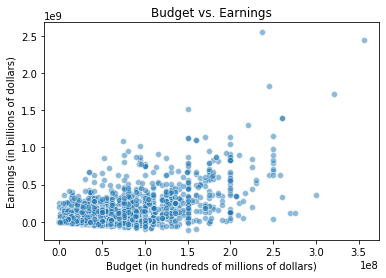

Pearson Correlation Coefficient: 0.6489519253306044


In [124]:
sns.scatterplot(x = "budget", y = "earnings", data = movies_df, alpha = .5)
plt.xlabel("Budget (in hundreds of millions of dollars)")
plt.ylabel("Earnings (in billions of dollars)")
plt.title("Budget vs. Earnings")
plt.show()
print("Pearson Correlation Coefficient: " + str(scipy.stats.pearsonr(movies_df.budget, movies_df.earnings)[0]))

The scatterplot and pearson correlation coefficient indicate that there is a moderate, positive, and linear correlation between budget and earnings. This make sense as higher budget movies will have more money for production and marketing, leading to more people seeing the movie and therefore larger earnings

Now, we'll take a look at the correlation between Rotten Tomatoes Rating, Rotten Tomatoes Status, Rotten Tomatoes Audience Rating and earnings

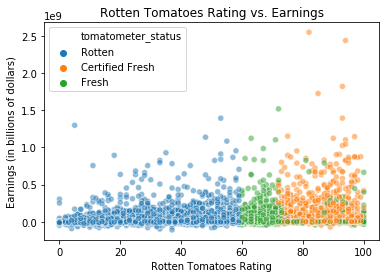

Pearson Correlation Coefficient: 0.1915282211747506


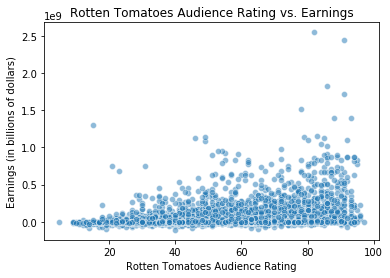

Pearson Correlation Coefficient: 0.24465953949415498


In [125]:
sns.scatterplot(x = "tomatometer_rating", y = "earnings", data = movies_df, hue = "tomatometer_status", alpha = .5)
plt.xlabel("Rotten Tomatoes Rating")
plt.ylabel("Earnings (in billions of dollars)")
plt.title("Rotten Tomatoes Rating vs. Earnings")
plt.show()
print("Pearson Correlation Coefficient: " + str(scipy.stats.pearsonr(movies_df.tomatometer_rating, movies_df.earnings)[0]))

sns.scatterplot(x = "audience_rating", y = "earnings", data = movies_df, alpha = .5)
plt.xlabel("Rotten Tomatoes Audience Rating")
plt.ylabel("Earnings (in billions of dollars)")
plt.title("Rotten Tomatoes Audience Rating vs. Earnings")
plt.show()
print("Pearson Correlation Coefficient: " + str(scipy.stats.pearsonr(movies_df.audience_rating, movies_df.earnings)[0]))

The scatterplots and pearson correlation coefficients indicate that there is a small, positive, and linear correlation between Rotten Tomatoes Rating and earnings, and a slightly larger, positive, and linear correlation between Rotten Tomatoes Audience Rating and earnings. This seems to indicate that "The Rotten Tomatoes Effect", the idea that a film's Rotten Tomatoes Rating will impact its box office performance, is likely false or heavily exagerrated.

Now, we'll take a look at how the correlation between Rotten Tomatoes Rating, Rotten Tomatoes Audience Rating, and earnings has changed over time. It would make sense that, as the Rotten Tomatoes site has grown more and more popular, the correlation between the two would increase if a film's Rotten Tomatoes Rating did impact its box office performance.

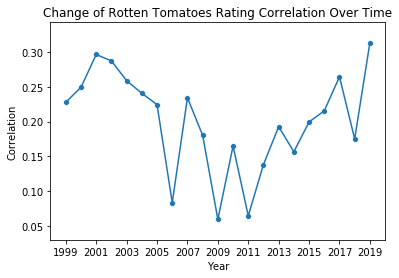

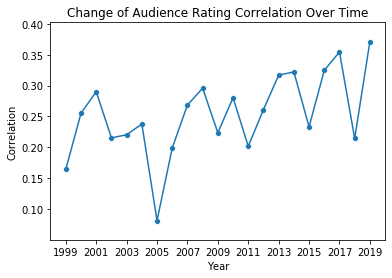

In [126]:
years = list(set(movies_df.year.values))
t_corr = []
a_corr = []
for y in years :
    temp_df = movies_df[movies_df.year == y]
    t_corr.append(scipy.stats.pearsonr(temp_df.tomatometer_rating, temp_df.earnings)[0])
    a_corr.append(scipy.stats.pearsonr(temp_df.audience_rating, temp_df.earnings)[0])
correlation_year_df = pd.DataFrame({"year" : years, "tomatometer_correlation" : t_corr, "audience_correlation" : a_corr})
    
sns.scatterplot(x = "year", y = "tomatometer_correlation", data = correlation_year_df)
sns.lineplot(x = "year", y = "tomatometer_correlation", data = correlation_year_df)
plt.xticks([1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019])
plt.xlabel("Year")
plt.ylabel("Correlation")
plt.title("Change of Rotten Tomatoes Rating Correlation Over Time")
plt.show()

sns.scatterplot(x = "year", y = "audience_correlation", data = correlation_year_df)
sns.lineplot(x = "year", y = "audience_correlation", data = correlation_year_df)
plt.xticks([1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019])
plt.xlabel("Year")
plt.ylabel("Correlation")
plt.title("Change of Audience Rating Correlation Over Time")
plt.show()

Based on these scatterplots, the correlation between Rotten Tomatoes Rating and earnings started higher approximately .25 - .3 when the Rotten Tomatoes site first launched, decreased over time until around 2008 - 2011 when it reached approximately .10, and then increased over time until present day where it has reached approximately .25 - .3 again. The correlation between Rotten Tomatoes Audience Rating and earnings has generally increased over time, starting at approximately .20 when the Rotten Tomatoes site first launched and reaching approximately .35 in the present day.